# Modelling notebook: Feature Engineering

## 1. Import Packages & Data

In [1]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.2.1

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 25.5 MB/s eta 0:00:00


In [2]:
!pip install -U neptune-client
!pip install -U neptune-sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 7.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

import neptune.new as neptune
import neptune.new.integrations.sklearn as npt_utils

The scikit-learn version is 1.2.1.


/usr/local/lib/python3.9/dist-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
<ipython-input-3-53664e2ef689>:4: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


In [4]:
# data processing
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import missingno
from scipy import stats

# modelling
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, \
RandomizedSearchCV, train_test_split, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from xgboost import XGBClassifier, plot_importance
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from scipy.stats import uniform, randint

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# other
from tqdm import tqdm
import pickle
import os
import sys
seed=42

In [5]:
pd.__version__

'1.4.4'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# importing data and helper functions from directories dependent on which is available

joseph_path = '/content/drive/My Drive/DS_Modules/CA4021 (Final Year Project)/' # Joseph
julita_path = '/content/drive/My Drive/CA4021 (Final Year Project)/' # Julita

if os.path.exists(joseph_path):
  print("Importing from DS_Modules/CA4021")
  sys.path.append(os.path.join(joseph_path, 'scripts'))
  path = joseph_path

elif os.path.exists(julita_path):
  print("Importing directly from CA4021 folder")
  sys.path.append(sys.path.append(os.path.join(julita_path, 'scripts')))
  path = julita_path

Importing from DS_Modules/CA4021


In [8]:
# import helper functions from aux file (prevents too much function definitions in the notebook)
from aux_functions import missing_percentages, plot_dist_discrete, plot_dist_continuous, \
plot_vis_discrete, plot_vis_continuous, month_vplot

from aux_functions_ml import preprocess, manual_cross_validate, get_feat_importance_df, \
performance_report, calc_mean_importance, plot_importance, heidke_skill_score, score_model, display_scores

In [9]:
# import train/valid and test sets
df_train = pd.read_csv(os.path.join(path, 'data/train_data.csv'))
df_train.index=pd.to_datetime(df_train.date_time)
df_train.date_time = df_train.index

df_test = pd.read_csv(os.path.join(path, 'data/test_data.csv'))
df_test.index=pd.to_datetime(df_test.date_time)
df_test.date_time = df_test.index

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print("Train/valid:", df_train.shape)
print("Test:", df_test.shape)

Train/valid: (78888, 57)
Test: (17544, 57)


In [10]:
# LEAVING OUT w, ww, pweather and weather because of OH encoding sparsity

metadata = ['date', 'date_time', 'year', 'month', 'day', 'hour', 'season']
indicator = [col for col in df_train.columns if col[0] == 'i']
constant = [var for var in df_train.columns if len(df_train[var].value_counts()) == 1]
codes = ['sp1', 'sp2', 'sp3', 'sp4', 'wwa', 'wa', 'w' ,'ww', 'pweather', 'weather']
excluded = indicator + constant + codes + ['rgauge', 'sog', 'tabspeed', 'msl']
vis_vars=['target_hr1', 'vis_hr1', 'fog_formation', 'fog_dissipation', 'transition']
target = 'target_hr1'

categorical=['fog_state', 'season', 'tsig1', 'tsig2', 'tsig3', 'pchar'] #'w', 'ww', 'pweather',
             #'weather']
discrete = [var for var in df_train.columns if len(df_train[var].unique()) < 15 and 
             var not in excluded + categorical + metadata + codes + indicator + vis_vars]

continuous = [var for var in df_train.columns if var not in discrete + excluded + categorical + metadata + codes + indicator + vis_vars]
numerical = discrete+continuous
# conservative list of variables known to have an impact on fog formation.
# the other lists are too big for certain visualisations
fog_vars = ['rainfall', 'drybulb', 'cbl', 'ntot', 'dni', 'dewpt', 'speed', 'dir', 'rh']

In [11]:
vars_sel = ['vis', 'temp_dew_dist', 'rh', 'ceiling', 'duration', 'hsig2', 'dni', 
                  'dewpt', 'drybulb', 'cbl', 'hlc', 'ntot', 'speed', 'vp', 'pchar','dir']
num_vars_sel = [var for var in vars_sel if var in discrete+continuous]
cat_vars_sel = [var for var in vars_sel if var in categorical]


In [12]:
dates = df_train.date_time
X = df_train[numerical + categorical + vis_vars].reset_index(drop=True)
y = X.pop(target)
X_full = pd.concat([X, y], axis=1)

# store dataframe of just selected features also. For feature engineering
X_sel = df_train[vars_sel+['transition', 'fog_state']].reset_index(drop=True)
y_sel = df_train[target].reset_index(drop=True)


In [ ]:
all(y_sel == y)

True

## Over & Undersampling
Resampling using **SMOTE** and **Random Undersampling of Majority class**.
By resampling time series data we lose the time series context, so we can't test for things like fog state transition scores. But we were able to train a model with the oversampled data to predict for in the normal unseen test set.

**SMOTE:** F1 score is good, but the ability of the model to predict state transitions is poor.
 **Random Undersampling of Majority class with 1:10 ratio:** F1 score is worse than without undersampling, and the transition scores are similar to model trained on non-undersampled data.



In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

### SMOTE

only used numerical features for smote

In [15]:
# doesn't include fog state or transition.

resampling_features = ['vis',
 'temp_dew_dist',
 'rh',
 'ceiling',
 'duration',
 'hsig2',
 'dni',
 'dewpt',
 'drybulb',
 'cbl',
 'hlc',
 'ntot',
 'speed',
 'vp',
 'pchar',
 'dir']
X_sel[resampling_features]

,vis,temp_dew_dist,rh,ceiling,duration,hsig2,dni,dewpt,drybulb,cbl,hlc,ntot,speed,vp,pchar,dir
0,9000,2.2,86,22,0.0,0.0,0,3.3,5.5,1017.1,22,7,7,7.8,5,27
1,9000,1.7,89,22,0.0,0.0,0,3.4,5.1,1017.1,22,7,6,7.8,5,28
2,8000,3.2,80,22,0.0,0.0,0,2.1,5.3,1016.8,22,7,6,7.1,8,27
3,8000,1.5,90,23,0.0,0.0,0,3.7,5.2,1016.6,23,7,7,8.0,7,25
4,8000,1.0,94,24,0.0,0.0,0,4.1,5.1,1016.6,24,7,7,8.2,6,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78883,16000,2.2,86,16,0.0,16.0,0,6.3,8.5,1020.1,9,8,4,9.6,6,12
78884,20000,3.3,79,18,0.0,18.0,0,5.2,8.5,1020.1,14,8,6,8.8,4,14
78885,20000,3.2,81,19,0.0,19.0,0,5.2,8.4,1019.8,14,8,4,8.9,8,14
78886,25000,3.9,77,22,0.0,22.0,0,4.3,8.2,1019.5,15,7,4,8.3,8,16


In [ ]:
# oversample using SMOTE
oversample = SMOTE(random_state=seed)
X_smt, y_smt = oversample.fit_resample(X_sel[resampling_features], y_sel)
X_smt = X_smt.reset_index(drop=True)

# enforce that visibility must be <= 1000 to be a fog event
y_smt = pd.Series(np.where(X_smt.vis <= 1000, 1, 0), name=target)
X_smt_full = pd.concat([X_smt, y_smt], axis=1)

In [ ]:
X_smt_full.target_hr1.value_counts()

0    104236
1     52340
Name: target_hr1, dtype: int64

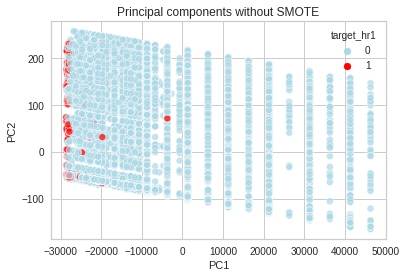

In [ ]:
sns.scatterplot(x='PC1', y='PC2', hue='target_hr1', 
                data=X_pca, 
                palette=['lightblue', 'red'],
                alpha=0.7)
plt.title('Principal components without SMOTE')
plt.show()

In [29]:
# compare the spread in PCA space
pca = PCA(n_components=2, random_state=seed)
X_pca = pd.DataFrame(pca.fit_transform(X_sel[resampling_features]), columns=['PC1', 'PC2'])
X_pca['target_hr1'] = X_full['target_hr1']


In [ ]:

pca_smote = PCA(n_components=2, random_state=seed)
X_smt_pca = pd.DataFrame(pca_smote.fit_transform(X_smt), columns=['PC1', 'PC2'])
X_smt_pca['target_hr1'] = X_smt_full['target_hr1']


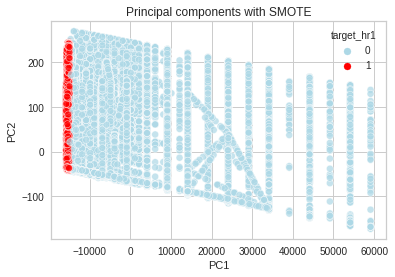

In [ ]:
sns.scatterplot(x='PC1', y='PC2', hue='target_hr1', 
                data=X_smt_pca, 
                palette=['lightblue', 'red'],
                alpha=0.7)
plt.title('Principal components with SMOTE')
plt.show()

In [ ]:
# initialise model with default parameters
model = XGBClassifier(objective='binary:logistic', random_state=seed)

Fold : 1
training size: (26096, 24)
test size: (26096, 24)
[[25843     0]
 [    0   253]]
****************************************************************************************************
Fold : 2
training size: (52192, 24)
test size: (26096, 24)
[[25954     0]
 [    0   142]]
****************************************************************************************************
Fold : 3
training size: (78288, 24)
test size: (26096, 24)
[[ 9019    20]
 [    0 17057]]
****************************************************************************************************
Fold : 4
training size: (104384, 24)
test size: (26096, 24)
[[ 8797     0]
 [    0 17299]]
****************************************************************************************************
Fold : 5
training size: (130480, 24)
test size: (26096, 24)
[[ 8707     0]
 [    0 17389]]
****************************************************************************************************


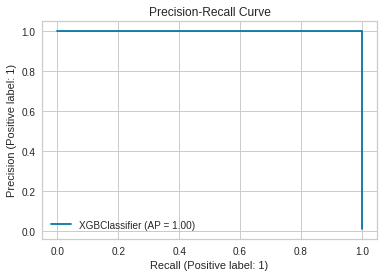

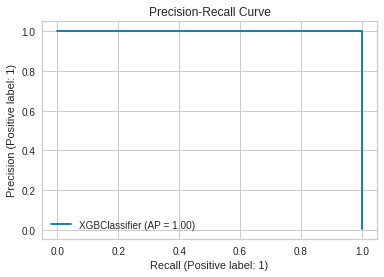

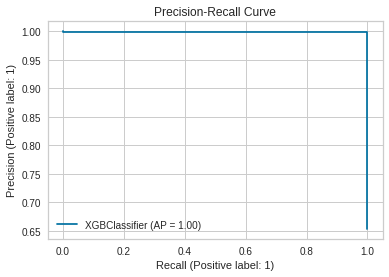

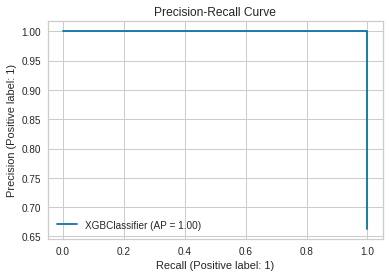

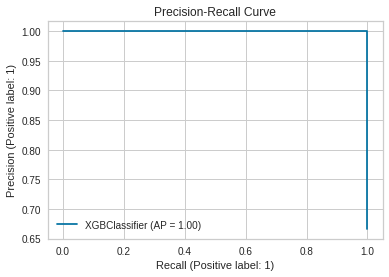

In [ ]:
smote_model_scores, _, _ = manual_cross_validate(model, X=X_smt, y=y_smt, 
                                                cat_vars=cat_vars_sel, 
                                                num_vars=num_vars_sel, 
                                                folds=5,
                                                cat_encoder='oh',
                                                calc_feature_importance=False,
                                                transitions=False)


In [ ]:
performance_report(smote_model_scores)

Validation Scores
------------------------------
f1_score
Scores: [100.0, 100.0, 99.94, 100.0, 100.0]
Mean: 99.988

heidke_skill_score
Scores: [1.0, 1.0, 0.9983, 1.0, 1.0]
Mean: 1.000

pr_auc
Scores: [1.0, 1.0, 0.9994, 1.0, 1.0]
Mean: 1.000



<ipython-input-120-f24be3f8ef38>:10: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/swiatej2/fyp/e/FYP-48
Validation Scores
------------------------------
pr_auc
Score: 0.5374

f1
Score: 64.86

hss
Score: 0.6457

confusion_matrix
Score: [[17344    52]
 [   52    96]]

transition_f1
Score: 29.79

transition_hss
Score: -0.2692

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 9 operations to synchronize with Neptune. Do not kill this process.
All 9 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/swiatej2/fyp/e/FYP-48/metadata


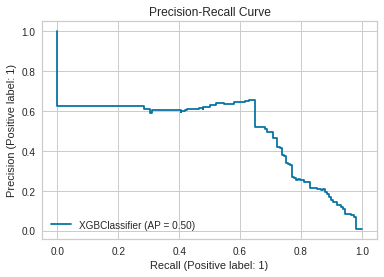

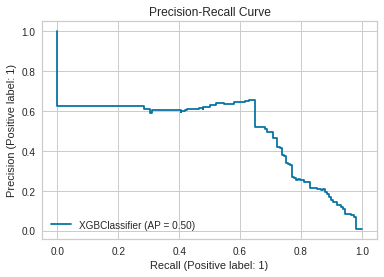

In [ ]:
# load hyperparameter search - error loading pickled file so manual copy paste here
best_params = {'colsample_bytree': 0.9040922615763338,
 'gamma': 0.2252496259847715,
 'learning_rate': 0.006979488347959958,
 'max_depth': 2,
 'n_estimators': 415,
 'subsample': 0.8253152871382157}

# try the SMOTE trained model on unseen test data
run = neptune.init_run(
    project='swiatej2/fyp',
    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjOTQxYjBkZS0zN2Y1LTRhYTQtOGQ1My03YTAxODJkM2E1OWMifQ==',
    name='XGB SMOTE',
    description='Testing XGBoost model SMOTE.',

)
X_train_smt, X_test = preprocess(X_smt, df_test, cat_vars=cat_vars_sel, num_vars=num_vars_sel, cat_encoder='oh')

y_train_smt = y_smt.copy()
y_test = df_test[target]

model = XGBClassifier(random_state=seed, **best_params)
model.fit(X_train_smt, y_train_smt)

scores, plots = score_model(model, X_train_smt, X_test, y_train_smt, y_test, df_test)
performance_report(scores)

run["algorithm"] = 'XGBoost (SMOTE)'
run["params"] = 'default'
run['metrics/f1'] = scores['f1']
run['metrics/hss'] = scores['hss']
run['metrics/transition_f1'] = scores['transition_f1']
run['metrics/transition_hss'] = scores['transition_hss']

# only include this for compatible models
run['metrics/pr_auc'] = scores['pr_auc']

# save Precision-Recall curve plot
img_path = os.path.join(path, 'images/xgb_pr_curve.png')
plots['pr_plot'].plot()
plt.title("Precision-Recall Curve")
plt.savefig(img_path)

run['plots/pr_curve'].upload(img_path)

run['plots/confusion_matrix'] = npt_utils.create_confusion_matrix_chart(model, X_train_smt, X_test, y_train_smt, y_test)

run.stop()


### Random Undersampling

In [ ]:
# Undersample using Random Undersampling of majority class
undersample = RandomUnderSampler(random_state=seed, sampling_strategy=0.1)
X_ru, y_ru = undersample.fit_resample(X_sel[resampling_features], y)
X_ru = X_ru.reset_index(drop=True)
X_ru_full = pd.concat([X_ru, y_ru], axis=1)

In [ ]:
df_train[target].value_counts()

0    78288
1      600
Name: target_hr1, dtype: int64

In [ ]:
X_ru_full[target].value_counts()

0    6000
1     600
Name: target_hr1, dtype: int64

In [ ]:
# compare the spread in PCA space
pca_ru = PCA(n_components=2, random_state=seed)
X_ru_pca = pd.DataFrame(pca_ru.fit_transform(X_ru), columns=['PC1', 'PC2'])
X_ru_pca['target_hr1'] = X_ru_full['target_hr1']


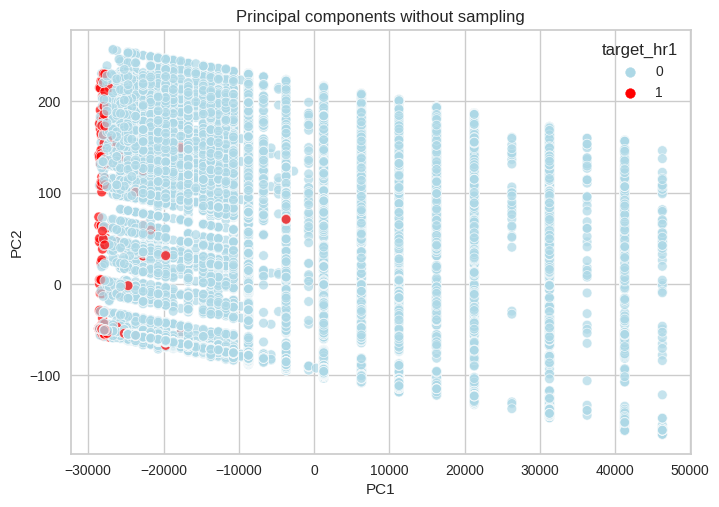

In [31]:
sns.scatterplot(x='PC1', y='PC2', hue='target_hr1', 
                data=X_pca, 
                palette=['lightblue', 'red'],
                alpha=0.7)
plt.title('Principal components without sampling')
plt.show()

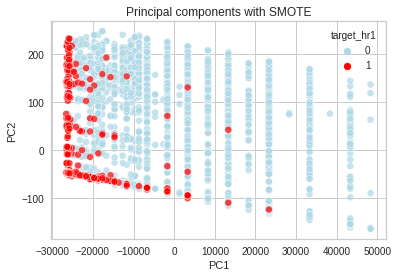

In [ ]:
sns.scatterplot(x='PC1', y='PC2', hue='target_hr1', 
                data=X_ru_pca, 
                palette=['lightblue', 'red'],
                alpha=0.7)
plt.title('Principal components with SMOTE')
plt.show()

In [ ]:
# initialise model with default parameters
model = XGBClassifier(objective='binary:logistic', random_state=seed)

https://app.neptune.ai/swiatej2/fyp/e/FYP-49
Validation Scores
------------------------------
pr_auc
Score: 0.5784

f1
Score: 55.9

hss
Score: 0.5543

confusion_matrix
Score: [[17263   133]
 [   39   109]]

transition_f1
Score: 37.5

transition_hss
Score: -0.2621

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 9 operations to synchronize with Neptune. Do not kill this process.
All 9 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/swiatej2/fyp/e/FYP-49/metadata


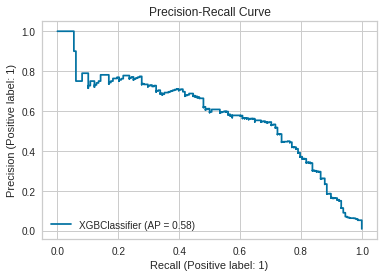

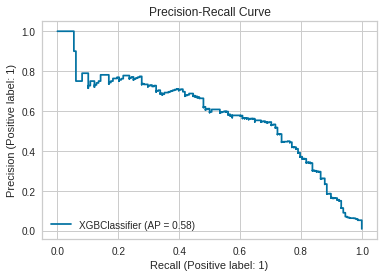

In [ ]:
# load hyperparameter search - error loading pickled file so manual copy paste here
best_params = {'colsample_bytree': 0.9040922615763338,
 'gamma': 0.2252496259847715,
 'learning_rate': 0.006979488347959958,
 'max_depth': 2,
 'n_estimators': 415,
 'subsample': 0.8253152871382157}

# try the SMOTE trained model on unseen test data
run = neptune.init_run(
    project='swiatej2/fyp',
    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjOTQxYjBkZS0zN2Y1LTRhYTQtOGQ1My03YTAxODJkM2E1OWMifQ==',
    name='XGB SMOTE',
    description='Testing XGBoost model with default parameters and SMOTE.',

)
X_train_ru, X_test = preprocess(X_ru, df_test, cat_vars=cat_vars_sel, num_vars=num_vars_sel, cat_encoder='oh')

y_train_ru = y_ru.copy()
y_test = df_test[target]

model = XGBClassifier(random_state=seed, **best_params)
model.fit(X_train_ru, y_train_ru)

scores, plots = score_model(model, X_train_ru, X_test, y_train_ru, y_test, df_test)
performance_report(scores)

run["algorithm"] = 'XGBoost (Random Undersampling (1:10))'
run["params"] = 'default'
run['metrics/f1'] = scores['f1']
run['metrics/hss'] = scores['hss']
run['metrics/transition_f1'] = scores['transition_f1']
run['metrics/transition_hss'] = scores['transition_hss']

# only include this for compatible models
run['metrics/pr_auc'] = scores['pr_auc']

# save Precision-Recall curve plot
img_path = os.path.join(path, 'images/xgb_pr_curve.png')
plots['pr_plot'].plot()
plt.title("Precision-Recall Curve")
plt.savefig(img_path)

run['plots/pr_curve'].upload(img_path)

run['plots/confusion_matrix'] = npt_utils.create_confusion_matrix_chart(model, X_train_ru, X_test, y_train_ru, y_test)

run.stop()


### Removing records with vis> 5,000

In this section, we try undersampling by removing observations with very high visibility. Note that these high visibilities aren't measured with as fine granularity as the lower visibilities

In [44]:
X_b5k = df_train.loc[df_train.vis <= 20000, resampling_features+[target]]
y_b5k = X_b5k.pop(target)
X_b5k.shape

(27360, 16)

In [45]:
# compare the spread in PCA space
pca_ru = PCA(n_components=2, random_state=seed)
X_b5k_pca = pd.DataFrame(pca_ru.fit_transform(X_b5k), columns=['PC1', 'PC2'])
X_b5k_pca['target_hr1'] = y_b5k.values

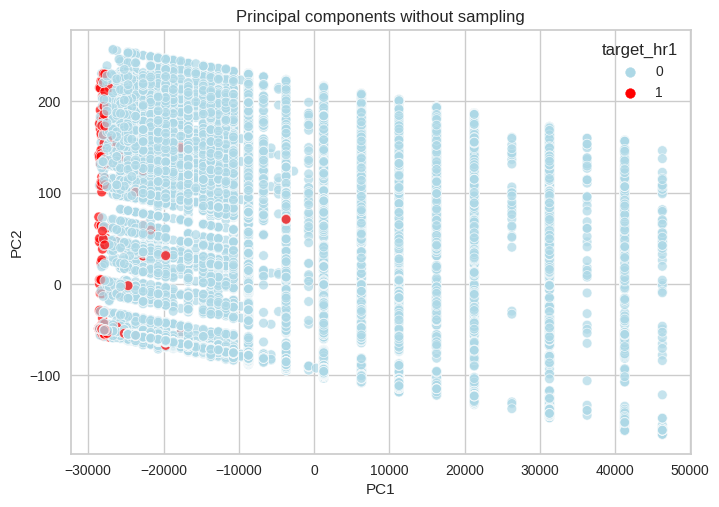

In [46]:
sns.scatterplot(x='PC1', y='PC2', hue='target_hr1', 
                data=X_pca, 
                palette=['lightblue', 'red'],
                alpha=0.7)
plt.title('Principal components without sampling')
plt.show()

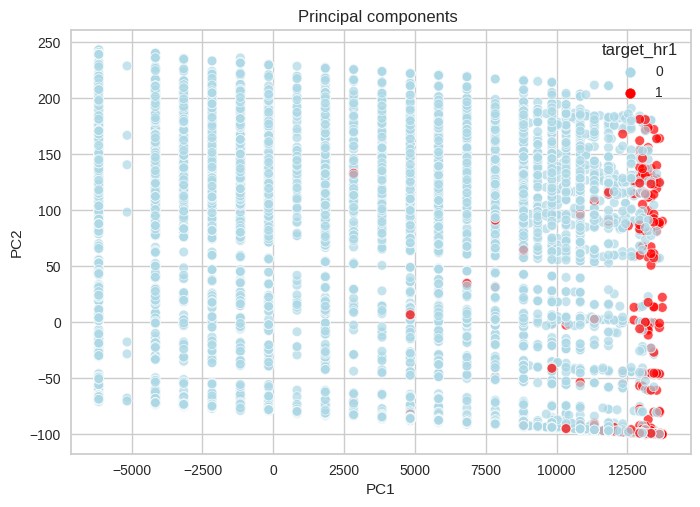

In [47]:
sns.scatterplot(x='PC1', y='PC2', hue='target_hr1', 
                data=X_b5k_pca, 
                palette=['lightblue', 'red'],
                alpha=0.7)
plt.title('Principal components ')
plt.show()

Validation Scores
------------------------------
pr_auc
Score: 0.6052

f1
Score: 66.67

hss
Score: 0.6641

confusion_matrix
Score: [[17362    34]
 [   57    91]]

transition_f1
Score: 30.12

transition_hss
Score: -0.1154



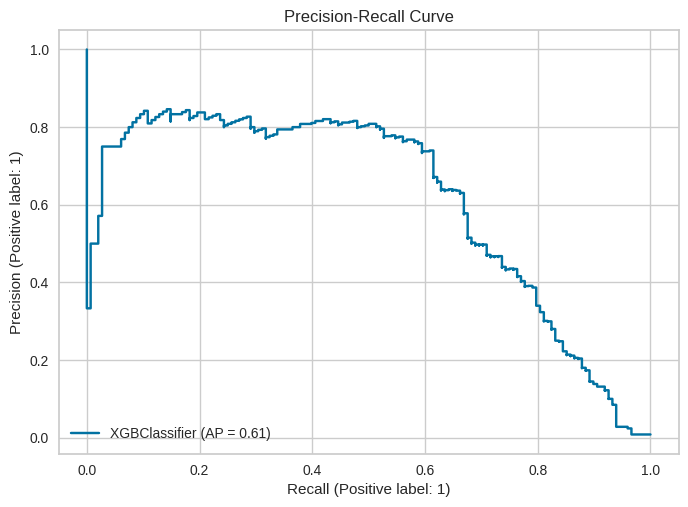

In [48]:
# load hyperparameter search - error loading pickled file so manual copy paste here
best_params = {'colsample_bytree': 0.9040922615763338,
 'gamma': 0.2252496259847715,
 'learning_rate': 0.006979488347959958,
 'max_depth': 2,
 'n_estimators': 415,
 'subsample': 0.8253152871382157}

X_train_b5k, X_test = preprocess(X_b5k, df_test, cat_vars=cat_vars_sel, num_vars=num_vars_sel, cat_encoder='oh')

y_train_b5k = y_b5k.copy()
y_test = df_test[target]

model = XGBClassifier(random_state=seed, **best_params)
model.fit(X_train_b5k, y_train_b5k)

scores, plots = score_model(model, X_train_b5k, X_test, y_train_b5k, y_test, df_test)
performance_report(scores)

In [49]:
# load hyperparameter search - error loading pickled file so manual copy paste here
best_params = {'colsample_bytree': 0.9040922615763338,
 'gamma': 0.2252496259847715,
 'learning_rate': 0.006979488347959958,
 'max_depth': 2,
 'n_estimators': 415,
 'subsample': 0.8253152871382157}

# try the SMOTE trained model on unseen test data
run = neptune.init_run(
    project='swiatej2/fyp',
    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjOTQxYjBkZS0zN2Y1LTRhYTQtOGQ1My03YTAxODJkM2E1OWMifQ==',
    name='XGB SMOTE',
    description='Testing XGBoost model SMOTE.',

)
X_train_smt, X_test = preprocess(X_smt, df_test, cat_vars=cat_vars_sel, num_vars=num_vars_sel, cat_encoder='oh')

y_train_smt = y_smt.copy()
y_test = df_test[target]

model = XGBClassifier(random_state=seed, **best_params)
model.fit(X_train_smt, y_train_smt)

scores, plots = score_model(model, X_train_smt, X_test, y_train_smt, y_test, df_test)
performance_report(scores)

run["algorithm"] = 'XGBoost (SMOTE)'
run["params"] = 'default'
run['metrics/f1'] = scores['f1']
run['metrics/hss'] = scores['hss']
run['metrics/transition_f1'] = scores['transition_f1']
run['metrics/transition_hss'] = scores['transition_hss']

# only include this for compatible models
run['metrics/pr_auc'] = scores['pr_auc']

# save Precision-Recall curve plot
img_path = os.path.join(path, 'images/xgb_pr_curve.png')
plots['pr_plot'].plot()
plt.title("Precision-Recall Curve")
plt.savefig(img_path)

run['plots/pr_curve'].upload(img_path)

run['plots/confusion_matrix'] = npt_utils.create_confusion_matrix_chart(model, X_train_smt, X_test, y_train_smt, y_test)

run.stop()


<ipython-input-49-f24be3f8ef38>:10: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/swiatej2/fyp/e/FYP-67


NameError: ignored

## Feature Engineering
Create additional variables and test if they improve model performance.

Tested the variables using forward selection from scratch, and by initialising with the 16 selected variables from previous notebooks (warm-start).

In [ ]:
def feature_eng(X, y, with_clusters=True):
  '''
    WARNING: since this function creates lag1 variables, the first row of the dataset is omitted.
    It's important to store the new X and y, as using the new X with a different y will lead to misalignment of datasets.

    given X and y datasets, return the datasets with feature engineering done

    Arguments:
      with_clusters: whether to a
  '''
  X_fe = X.copy()


  # load clusters from 0_5_2_lagged_clusters notebook
  x_train_clust = os.path.join(path, 'results/kmeans_lagged.pickle')
  with open(x_train_clust, 'rb') as file:
    clusters = pickle.load(file)

  # function for creating a direction for any vairable
  def get_direction(row, var):
    ''' Return up, down, or constant depending on the direction the variable went in comparison to the previous data point '''
    if row[var] < row[var+'_lag1']:
      return 'down'
    elif row[var] > row[var+'_lag1']:
      return 'up'
    else:
      return 'constant'

  # add lag1 of each feature to the dataset
  for col in X_fe.columns.tolist():
    if col not in ['transition']:
      col_lag1 = X_fe[col].shift(1)
      X_fe[col+'_lag1'] = col_lag1

  X_fe['vis_direction'] = X_fe.apply(lambda x: get_direction(x, 'vis'), axis=1)

  if with_clusters:
    X_fe['weather_cluster'] = clusters

  #X_fe[target] = y

  # align the target for forward selection
  X_fe = X_fe.iloc[1:]
  y_fe = y.iloc[1:]

  return X_fe, y_fe

  

X_fe, y_fe = feature_eng(X_sel, y_sel)

# divide features into types for preprocess
fe_cat = [col for col in X_fe.columns if len(X_fe[col].unique()) < 5 and col not in [target, 'transition']]
fe_num = [col for col in X_fe.columns if col not in fe_cat and col != target]

In [ ]:
from sklearn.model_selection import train_test_split

def forward_selection(model, X_train, y_train, features, 
                      starting_vars=[], 
                      metric='average_precision'):
    '''
      TS-CV Forward selection to add new variables from feature engineering.
      We need this function instead of the MLExtend inbuilt functionso we can 
      use warm-start variables (starting_vars).
      
      Also we can do preprocessing right before model training, allowing us to see the impact of categorical variables
      on predictions in terms of all the onehot encoded columns at once, not individually. Looking at
      performance gains for each onehot column individually would not be informative for the feature selection.
    '''
    # start with original variables from XGBoost notebook
    tss = TimeSeriesSplit(n_splits=5)
    selected_features = starting_vars

    best_score = 0
    iter_no = 1
    while True:
        remaining_features = [f for f in features if f not in selected_features]

        # if we're done and all the features were added, end
        if len(remaining_features) == 0:
            break
        scores = []
        print("Iteration no {} of {}".format(iter_no, len(features)))
        print("-"*30)
        for feature in remaining_features:
            X = X_train[selected_features + [feature]]

            cat_vars = [var for var in X.columns if var in fe_cat]
            num_vars = [var for var in X.columns if var in fe_num]

            # preprocess the data using our helper function
            X_train_p = preprocess(X, X_test=None,
                       cat_vars=cat_vars, 
                       num_vars=num_vars, 
                       cat_encoder='oh',
                       prep_test=False)

            score = cross_val_score(model, X=X_train_p, y=y_train, cv=tss, scoring=metric).mean()

            print("PR-AUC Score after adding {}: {:.4f}".format(feature, score))
            scores.append((score, feature))
        
        best_new_score, best_new_feature = max(scores)
        if best_new_score > best_score:
            print("Adding {} to selected features.".format(best_new_feature))
            print()
            selected_features.append(best_new_feature)
            best_score = best_new_score
            iter_no += 1
        else:
          # if none of the variables at this step improved the model, end
            break
    return selected_features, best_score


model = XGBClassifier(random_state=seed)

In [ ]:
# Don't rerun!
# forward selection with warm-start (features from XGB gain importance already selected)
starting_vars = [col for col in X_sel.columns if col not in ['fog_state', 'transition']]
features = [col for col in X_fe.columns if col not in X_sel.columns.tolist()]

selected_features_ws, best_score_ws = forward_selection(model, X_fe, y_fe, features, starting_vars=starting_vars)
print('Selected Features:', selected_features_ws)

Iteration no 1 of 19
------------------------------
F1 Score after adding vis_lag1: 0.5758
F1 Score after adding temp_dew_dist_lag1: 0.5524
F1 Score after adding rh_lag1: 0.5686
F1 Score after adding ceiling_lag1: 0.5691
F1 Score after adding duration_lag1: 0.5659
F1 Score after adding hsig2_lag1: 0.5620
F1 Score after adding dni_lag1: 0.5655
F1 Score after adding dewpt_lag1: 0.5542
F1 Score after adding drybulb_lag1: 0.5543
F1 Score after adding cbl_lag1: 0.5718
F1 Score after adding hlc_lag1: 0.5608
F1 Score after adding ntot_lag1: 0.5634
F1 Score after adding speed_lag1: 0.5543
F1 Score after adding vp_lag1: 0.5720
F1 Score after adding pchar_lag1: 0.5551
F1 Score after adding dir_lag1: 0.5419
F1 Score after adding fog_state_lag1: 0.5416
F1 Score after adding vis_direction: 0.5506
F1 Score after adding weather_cluster: 0.5598
Adding vis_lag1 to selected features.

Iteration no 2 of 19
------------------------------
F1 Score after adding temp_dew_dist_lag1: 0.5657
F1 Score after addi

In [ ]:
# Don't rerun!
# normal forward selection (starting just with vis)
features = [col for col in X_fe.columns if col not in ['vis', 'transition']]
selected_features_sc, best_score_sc = forward_selection(model, X_fe, y_fe, features, starting_vars=['vis'])

print('Selected Features:', selected_features_sc)
print('Best Score:', best_score_sc)

Iteration no 1 of 35
------------------------------
F1 Score after adding temp_dew_dist: 0.5375
F1 Score after adding rh: 0.5419
F1 Score after adding ceiling: 0.5805
F1 Score after adding duration: 0.5734
F1 Score after adding hsig2: 0.5483
F1 Score after adding dni: 0.5648
F1 Score after adding dewpt: 0.5409
F1 Score after adding drybulb: 0.5537
F1 Score after adding cbl: 0.5116
F1 Score after adding hlc: 0.5761
F1 Score after adding ntot: 0.5668
F1 Score after adding speed: 0.5368
F1 Score after adding vp: 0.5383
F1 Score after adding pchar: 0.5450
F1 Score after adding dir: 0.5345
F1 Score after adding fog_state: 0.5652
F1 Score after adding vis_lag1: 0.5299
F1 Score after adding temp_dew_dist_lag1: 0.5360
F1 Score after adding rh_lag1: 0.5631
F1 Score after adding ceiling_lag1: 0.5567
F1 Score after adding duration_lag1: 0.5721
F1 Score after adding hsig2_lag1: 0.5725
F1 Score after adding dni_lag1: 0.5595
F1 Score after adding dewpt_lag1: 0.5251
F1 Score after adding drybulb_lag1

In [ ]:
# save results
ws_results = {}
ws_results['features'] = selected_features_ws
ws_results['f1'] = best_score_ws

ws_results_path = os.path.join(path, 'results/selected_features_warmstart.pickle')
with open(ws_results_path, 'wb') as file:
  pickle.dump(ws_results, file)
print("Extracted results to {}".format(ws_results_path))

print(selected_features_ws)
print('Best Score (FS warm-start): {}'.format(np.round(best_score_ws, 4)))

Extracted results to /content/drive/My Drive/DS_Modules/CA4021 (Final Year Project)/results/selected_features_warmstart.pickle
['vis', 'temp_dew_dist', 'rh', 'ceiling', 'duration', 'hsig2', 'dni', 'dewpt', 'drybulb', 'cbl', 'hlc', 'ntot', 'speed', 'vp', 'pchar', 'dir', 'vis_lag1', 'vis_direction', 'rh_lag1', 'hlc_lag1']
Best Score (FS warm-start): 0.5886


In [ ]:
# save results
sc_results = {}
sc_results['features'] = selected_features_sc
sc_results['f1'] = best_score_sc

sc_results_path = os.path.join(path, 'results/selected_features_scratch.pickle')
with open(sc_results_path, 'wb') as file:
  pickle.dump(sc_results, file)
print("Extracted results to {}".format(sc_results_path))

print(selected_features_sc)
print("Best score (FS from scratch): {}".format(best_score_sc))

Extracted results to /content/drive/My Drive/DS_Modules/CA4021 (Final Year Project)/results/selected_features_scratch.pickle
['vis', 'ceiling', 'duration', 'dni', 'duration_lag1']
Best score (FS from scratch): 0.5935585950217415


##  Final Evaluation

Full evaluation of the feature sets from forward selection.

**Train/Valid Results:** Using cross validation, saw that the best performance was when using all the new features, followed by the warm-start FS and then the FS from scratch.

Because of this, we tested only the model with all the new features on the unseen test set.

**Test Results:**

In [ ]:
# load hyperparameter search - error loading pickled file so manual copy paste here
best_params = {'colsample_bytree': 0.9040922615763338,
 'gamma': 0.2252496259847715,
 'learning_rate': 0.006979488347959958,
 'max_depth': 2,
 'n_estimators': 415,
 'subsample': 0.8253152871382157}

model = XGBClassifier(**best_params, random_state=seed)

In [ ]:
# Test 1: Cross validation with all the new variables
model = XGBClassifier(**best_params, random_state=seed)
features = [col for col in X_fe.columns if col not in [target, 'transition']]
cat_vars = fe_cat
num_vars = [col for col in features if col not in cat_vars]

In [ ]:
all_var_score, _, _ = manual_cross_validate(model, X=X_fe, y=y_fe, 
                                                cat_vars=cat_vars, 
                                                num_vars=num_vars, 
                                                folds=5,
                                                cat_encoder='oh',
                                                calc_feature_importance=False,
                                                transitions=True,
                                            verbose=False,
                                            plot=False)
performance_report(all_var_score)

Fold : 1
Fold : 2
Fold : 3
Fold : 4
Fold : 5
Validation Scores
------------------------------
f1_score
Scores: [64.36, 67.54, 67.4, 56.58, 57.14]
Mean: 62.604

heidke_skill_score
Scores: [0.6408, 0.6716, 0.6718, 0.5633, 0.5698]
Mean: 0.623

transition_f1_score
Scores: [26.09, 32.79, 26.09, 27.66, 29.41]
Mean: 28.408

transition_hss_score
Scores: [-0.1797, -0.1998, -0.1982, -0.096, -0.0847]
Mean: -0.152



In [ ]:
# Test 2: Cross validation with FS variables with warm-start
# import feature set from results
model = XGBClassifier(**best_params, random_state=seed)
ws_results_path = os.path.join(path, 'results/selected_features_warmstart.pickle')
with open(ws_results_path, 'rb') as file:
  selected_features_ws = pickle.load(file)['features']

features = selected_features_ws
cat_vars = [col for col in features if col in fe_cat]
num_vars = [col for col in features if col not in cat_vars]

ws_score, _, _ = manual_cross_validate(model, X=X_fe, y=y_fe, 
                                                cat_vars=cat_vars, 
                                                num_vars=num_vars, 
                                                folds=5,
                                                cat_encoder='oh',
                                                calc_feature_importance=False,
                                                transitions=True,
                                       verbose=False,
                                       plot=False)
performance_report(ws_score)

Fold : 1
training size: (13152, 22)
test size: (13147, 22)
[[13012    23]
 [   48    64]]
****************************************************************************************************
Fold : 2
training size: (26299, 22)
test size: (13147, 22)
[[12946    40]
 [   59   102]]
****************************************************************************************************
Fold : 3
training size: (39446, 22)
test size: (13147, 22)
[[13032    20]
 [   35    60]]
****************************************************************************************************
Fold : 4
training size: (52593, 22)
test size: (13147, 22)
[[13041    17]
 [   47    42]]
****************************************************************************************************
Fold : 5
training size: (65740, 22)
test size: (13147, 22)
[[13077    15]
 [   32    23]]
****************************************************************************************************
Validation Scores
---------------------------

In [ ]:
# Test 3: Cross validation with FS variables from scratch
# import feature set
sc_results_path = os.path.join(path, 'results/selected_features_scratch.pickle')
with open(sc_results_path, 'rb') as file:
  selected_features_sc = pickle.load(file)['features']

features = selected_features_sc
cat_vars = [col for col in features if col in fe_cat]
num_vars = [col for col in features if col not in cat_vars]

sc_score, _, _ = manual_cross_validate(model, X=X_fe, y=y_fe, 
                                                cat_vars=cat_vars, 
                                                num_vars=num_vars, 
                                                folds=5,
                                                cat_encoder='oh',
                                                calc_feature_importance=False,
                                                verbose=False,
                                                plot=False)

performance_report(sc_score)

Fold : 1
Fold : 2
Fold : 3
Fold : 4
Fold : 5
Validation Scores
------------------------------
f1_score
Scores: [65.35, 66.44, 65.88, 54.79, 50.0]
Mean: 60.492

heidke_skill_score
Scores: [0.6508, 0.6607, 0.6566, 0.5455, 0.4982]
Mean: 0.602

transition_f1_score
Scores: [28.07, 28.57, 28.57, 27.59, 20.29]
Mean: 26.618

transition_hss_score
Scores: [-0.1406, -0.1478, -0.0959, -0.0413, -0.2371]
Mean: -0.133



Since the model with all the new features added shows the best performance on the test/validaiton set, we now evaluate it on the unseen test set.

In [ ]:
# equivalent feature engineering for the test set
X_test_sel = df_test[vars_sel+['transition', 'fog_state']]
y_test_sel = df_test[target]

X_test_fe, y_test_fe = feature_eng(X_test_sel, y_test_sel, with_clusters=False)

In [ ]:
# testing the updated preprocessing and training setup
features = [col for col in X_fe.columns if col not in [target, 'transition', 'weather_cluster']]
cat_vars = ['fog_state', 'fog_state_lag1', 'vis_direction']
num_vars = [
'vis',
'temp_dew_dist',
'rh',
'ceiling',
'duration',
'hsig2',
'dni',
'dewpt',
'drybulb',
'cbl',
'hlc',
'ntot',
'speed',
'vp',
'pchar',
'dir',
'vis_lag1',
'temp_dew_dist_lag1',
'rh_lag1',
'ceiling_lag1',
'duration_lag1',
'hsig2_lag1',
'dni_lag1',
'dewpt_lag1',
'drybulb_lag1',
'cbl_lag1',
'hlc_lag1',
'ntot_lag1',
'speed_lag1',
'vp_lag1',
'pchar_lag1',
'dir_lag1'
]


In [ ]:
X_train, X_test = preprocess(X_fe, X_test_fe, cat_vars=cat_vars, num_vars=num_vars, cat_encoder='oh')

y_train = y_fe.copy()
y_test = y_test_fe.copy()

In [ ]:
# log performance on the unseen test set into Neptune

final_model = XGBClassifier(**best_params, objective='binary:logistic', random_state=seed)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)


In [ ]:

run = neptune.init_run(
    project='swiatej2/fyp',
    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjOTQxYjBkZS0zN2Y1LTRhYTQtOGQ1My03YTAxODJkM2E1OWMifQ==',
    name='XGB Test',
    description='XGBoost with all the new features added',

)

final_scores, final_plots = score_model(final_model, X_train, X_test, y_train, y_test, X_test_fe)
performance_report(final_scores)

run["algorithm"] = "XGBoost (+19FE features)"
run["params"] = best_params
run['metrics/f1'] = final_scores['f1']
run['metrics/hss'] = final_scores['hss']
run['metrics/transition_f1'] = final_scores['transition_f1']
run['metrics/transition_hss'] = final_scores['transition_hss']

run["features"] = features
# only include this for compatible models
run['metrics/pr_auc'] = final_scores['pr_auc']

# save Precision-Recall curve plot
img_path = os.path.join(path, 'images/xgb_pr_curve.png')
final_plots['pr_plot'].plot()
plt.title("Precision-Recall Curve")
plt.savefig(img_path)

run['plots/pr_curve'].upload(img_path)

run['plots/confusion_matrix'] = npt_utils.create_confusion_matrix_chart(final_model, X_train, X_test, y_train, y_test)

run.stop()


## Fog Formation Eval

We saw from the performance metrics that the model can predict fog states with some success, but overall fail to predict fog state transitions. As in, they can't predict accurately when a fog episode will begin. In this section, we evaluate how well the xgboost model can predict fog episodes when we give wider margins of error.

**Result:**
- When considering longer lead-times, XGBoost model caught more transitions than for just the 1 hour lead time, but not significantly more. A bigger problem is the fog formations it didn't detect at all.

**Notes:**
- Actual vs Predicted plot shows that the model is identifying fog episodes.
- Closer look at actual vs predicted tables shows that the model is underpredicting fog slightly, and the number of hourly fog instances it detected is roughly the same as the number it missed (91, 92).
- Specifically inspecting fog formation predictions, we see that out of the 42 fog formation predictions, 25 of these were too late (there was already fog). Of the other 17 where there was no fog, all of them are actually fog dissipation instances, where in the next hour the fog stopped. This suggests that the predicitions were actually late here also. **The model has a lagged reaction to fog state transition**
- Analysing the 17 cases of fog formation predictions to see if there was actually fog formation within 3 hours, 6 hours, and 12 hours, we see that when the model predicted fog, there was fog within 3 to 6 hours in 17% of cases, and within 12 hours in 23.5% of cases.
 <br>



In [ ]:
y_pred = pd.Series(y_pred, name='pred')

In [ ]:
y_pred

0        0
1        0
2        0
3        0
4        0
        ..
17538    0
17539    0
17540    0
17541    0
17542    0
Name: pred, Length: 17543, dtype: int64

In [ ]:
y_test

0        0
1        0
2        0
3        0
4        0
        ..
17538    0
17539    0
17540    0
17541    0
17542    0
Name: target_hr1, Length: 17543, dtype: int64

In [ ]:
target_df = pd.DataFrame({'pred': y_pred, 'label': y_test})
target_df.index = y_test_fe.index

In [ ]:
target_df

,pred,label
date_time,,
2020-01-01 01:00:00,0,0
2020-01-01 02:00:00,0,0
2020-01-01 03:00:00,0,0
2020-01-01 04:00:00,0,0
2020-01-01 05:00:00,0,0
...,...,...
2021-12-31 19:00:00,0,0
2021-12-31 20:00:00,0,0
2021-12-31 21:00:00,0,0


In [ ]:
# build predicted fog state transition variables
formation = []
dissipation = []
fog_flag = False
for index, row in target_df.iterrows():
  # case 1: fog formation
  if row['pred'] == 1 and not fog_flag:
    formation.append(1)
    dissipation.append(0)
    fog_flag = True
  # case 2: fog dissipation
  elif row['pred'] == 0 and fog_flag:
    dissipation.append(1)
    formation.append(0)
    fog_flag = False
  # case 3: not a fog transition
  else:
    formation.append(0)
    dissipation.append(0)

target_df['pred_formation'] = formation
target_df['pred_dissipation'] = dissipation
#target_df['pred_transition'] = np.where((target_df.pred_formation == 1)|(target_df.pred_dissipation == 1), 1, 0)

In [ ]:
target_df['formation'] = df_test['fog_formation']
target_df['dissipation'] = df_test['fog_dissipation']
target_df['fog_state'] = df_test['fog_state']

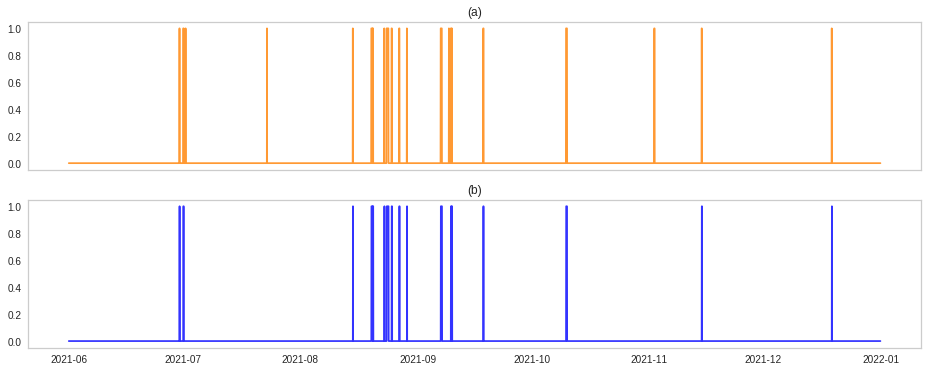

In [ ]:
# (a) is actual fog episodes in second half of 2021
# (b) is predicted fog episodes by best XGBoost model in second half of 2021
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 6), sharex=True)

ax1.plot(target_df.loc[target_df.index >= '2021-06', ['label']], 
         alpha=0.8, linestyle='-', color='#FF8000')
ax1.set_title('(a)')

ax2.plot(target_df.loc[target_df.index >= '2021-06', ['pred']], 
         alpha=0.8, linestyle='-', color='blue')
ax2.set_title('(b)')

ax1.grid(False)
ax2.grid(False)

plt.show()

In [ ]:
# model tends to underpredict fog rather than overpredict
target_df.loc[:,['pred', 'label']].value_counts()

pred  label
0     0        17361
1     1           91
0     1           57
1     0           34
dtype: int64

In [ ]:
confusion_matrix(target_df['pred'], target_df['label'])

array([[17361,    57],
       [   34,    91]])

In [ ]:
# in 17 cases,  predicts fog formation in an hour, but it didn't occur in an hour
# most of the time when the model predicts fog formation, there is already fog. (25/42)
target_df.loc[:,['pred_formation', 'label']].value_counts()

pred_formation  label
0               0        17378
                1          123
1               1           25
                0           17
dtype: int64

In [ ]:
# the model didn't predict any fog formations correctly with 1hr lead time.
target_df.loc[:,['pred_formation', 'formation']].value_counts()

pred_formation  formation
0               0            17449
                1               52
1               0               42
dtype: int64

In [ ]:
# get the indices of target_df where fog formation predicted but there wasn't fog yet.
td_no_idx = target_df.reset_index()
pred_form_idx = td_no_idx.loc[(td_no_idx['pred_formation'] == 1) & (td_no_idx['label'] == 0), ['pred', 'pred_formation', 'label']].index

In [ ]:
# all the cases of predicted formation in next hour were actually cases of fog dissipating in the next hour!
# suggests the prediction is late in these cases
td_no_idx.iloc[pred_form_idx]

,date_time,pred,label,pred_formation,pred_dissipation,formation,dissipation,fog_state
5454,2020-08-15 07:00:00,1,0,1,0,0,1,fog
5515,2020-08-17 20:00:00,1,0,1,0,0,1,fog
5549,2020-08-19 06:00:00,1,0,1,0,0,1,fog
5562,2020-08-19 19:00:00,1,0,1,0,0,1,fog
6333,2020-09-20 22:00:00,1,0,1,0,0,1,fog
6669,2020-10-04 22:00:00,1,0,1,0,0,1,fog
7539,2020-11-10 04:00:00,1,0,1,0,0,1,fog
8207,2020-12-08 00:00:00,1,0,1,0,0,1,fog
8261,2020-12-10 06:00:00,1,0,1,0,0,1,fog
8263,2020-12-10 08:00:00,1,0,1,0,0,1,fog


In [ ]:
# for each index in pred_form_idx, check the next indices for fog formation.
n_cases = len(pred_form_idx)
three_hr = 0
six_hr = 0
twelve_hr = 0
for idx in pred_form_idx:
  # 3hr lead time
  if any(td_no_idx.iloc[idx:idx+4,-3] == 1):
    twelve_hr += 1
    six_hr += 1
    three_hr += 1
  # 6hr lead time - if formation within 6 hrs, then formation within 12 also
  elif any(td_no_idx.iloc[idx:idx+7,-3] == 1):
    six_hr += 1
    twelve_hr += 1
  elif any(td_no_idx.iloc[idx:idx+13,-3] == 1):
    twelve_hr += 1

In [ ]:
three_hr_prop = np.round((three_hr / n_cases)*100, 2)
six_hr_prop = np.round((six_hr / n_cases)*100, 2)
twelve_hr_prop = np.round((twelve_hr / n_cases)*100, 2)

In [ ]:
print("three hr lead time: {}/{}".format(three_hr, n_cases))
print("six hr lead time: {}/{}".format(six_hr, n_cases))
print("twelve hr lead time: {}/{}".format(twelve_hr, n_cases))

three hr lead time: 3/17
six hr lead time: 3/17
twelve hr lead time: 4/17


In [ ]:
print("% Of cases where model predicts fog and fog occurs within 3 hours: {}".format(three_hr_prop))
print("% Of cases where model predicts fog and fog occurs within 6 hours: {}".format(six_hr_prop))
print("% Of cases where model predicts fog and fog occurs within 12 hours: {}".format(twelve_hr_prop))

% Of cases where model predicts fog and fog occurs within 3 hours: 17.65
% Of cases where model predicts fog and fog occurs within 6 hours: 17.65
% Of cases where model predicts fog and fog occurs within 12 hours: 23.53


## Data Export

Export dataset with the selected features and feature engineering done

In [ ]:
# equivalent feature engineering for the test set
X_fe.shape, y_fe.shape, X_test_fe.shape, y_test_fe.shape

((78887, 37), (78887,), (17543, 36), (17543,))

In [ ]:
train_fe = pd.concat([X_fe, y_fe], axis=1)
test_fe = pd.concat([X_test_fe, y_test_fe], axis=1)

train_fe_path = os.path.join(path, 'data/train_data_fe.csv')
test_fe_path = os.path.join(path, 'data/test_data_fe.csv')

train_fe.to_csv(train_fe_path)
test_fe.to_csv(test_fe_path)
print("Exported new train set to {}\nExported new test set to {}".format(train_fe_path, test_fe_path))

Exported new train set to /content/drive/My Drive/DS_Modules/CA4021 (Final Year Project)/data/train_data_fe.csv
Exported new test set to /content/drive/My Drive/DS_Modules/CA4021 (Final Year Project)/data/test_data_fe.csv


In [ ]:
X_fe.shape

(78887, 37)

In [ ]:
X_fe.columns

Index(['vis', 'temp_dew_dist', 'rh', 'ceiling', 'duration', 'hsig2', 'dni', 'dewpt', 'drybulb', 'cbl', 'hlc', 'ntot', 'speed', 'vp', 'pchar', 'dir', 'transition', 'fog_state', 'vis_lag1', 'temp_dew_dist_lag1', 'rh_lag1', 'ceiling_lag1', 'duration_lag1', 'hsig2_lag1', 'dni_lag1', 'dewpt_lag1', 'drybulb_lag1', 'cbl_lag1', 'hlc_lag1', 'ntot_lag1', 'speed_lag1', 'vp_lag1', 'pchar_lag1', 'dir_lag1', 'fog_state_lag1', 'vis_direction', 'weather_cluster'], dtype='object')